In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from datasets import Dataset
import evaluate
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

### Load data

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
data = pd.read_csv("raw_combined_2.csv") 

# get the length of section
print("Total number of texts: ", len(data['text']))
print("Total number of labels: ", len(data['label']))

#get unique labels
unique_labels = list(set(data['label']))
print("The unique labels are: ", unique_labels)

Total number of texts:  1998
Total number of labels:  1998
The unique labels are:  [0, 1]


In [19]:
# First split: 80% (train+val) and 20% (test)
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_val_idx, test_idx in split1.split(data, data['label']):
    train_val_data = data.iloc[train_val_idx]
    test_data = data.iloc[test_idx]

# Second split: 60% train and 20% validation from 80% train+val
split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_idx, val_idx in split2.split(train_val_data, train_val_data['label']):
    train_data = train_val_data.iloc[train_idx]
    val_data = train_val_data.iloc[val_idx]

# Verify the splits on the labels
print("Train data: ", train_data['label'].value_counts(normalize=False))
print("Validation data: ", val_data['label'].value_counts(normalize=False))
print("Test data: ", test_data['label'].value_counts(normalize=False))

Train data:  label
0    664
1    534
Name: count, dtype: int64
Validation data:  label
0    222
1    178
Name: count, dtype: int64
Test data:  label
0    222
1    178
Name: count, dtype: int64


In [20]:
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": accuracy["accuracy"]}

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
train_dataset = Dataset.from_dict(train_data.to_dict(orient='list'))
val_dataset = Dataset.from_dict(val_data.to_dict(orient='list'))
test_dataset = Dataset.from_dict(test_data.to_dict(orient='list'))

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

# Initialize the model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(unique_labels))
model = model.to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir="./temp",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir=None,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",  # Matches the key in compute_metrics
    save_total_limit=2
)

# Define Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
# Train the model
trainer.train()

Map:   0%|          | 0/1198 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\gavin\.conda\envs\nlp\Lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


  0%|          | 0/114 [00:00<?, ?it/s]

{'loss': 0.5888, 'grad_norm': 2.0406720638275146, 'learning_rate': 1.824561403508772e-05, 'epoch': 0.26}
{'loss': 0.283, 'grad_norm': 1.6255041360855103, 'learning_rate': 1.649122807017544e-05, 'epoch': 0.53}
{'loss': 0.1351, 'grad_norm': 2.4084293842315674, 'learning_rate': 1.4736842105263159e-05, 'epoch': 0.79}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.04736839234828949, 'eval_accuracy': 0.995, 'eval_runtime': 21.338, 'eval_samples_per_second': 18.746, 'eval_steps_per_second': 0.328, 'epoch': 1.0}
{'loss': 0.0802, 'grad_norm': 0.845809280872345, 'learning_rate': 1.2982456140350879e-05, 'epoch': 1.05}
{'loss': 0.0523, 'grad_norm': 3.519592761993408, 'learning_rate': 1.1228070175438597e-05, 'epoch': 1.32}
{'loss': 0.0224, 'grad_norm': 0.2232259213924408, 'learning_rate': 9.473684210526315e-06, 'epoch': 1.58}
{'loss': 0.0189, 'grad_norm': 0.5334815382957458, 'learning_rate': 7.719298245614036e-06, 'epoch': 1.84}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.02018127590417862, 'eval_accuracy': 0.9975, 'eval_runtime': 19.0374, 'eval_samples_per_second': 21.011, 'eval_steps_per_second': 0.368, 'epoch': 2.0}
{'loss': 0.0373, 'grad_norm': 0.1712004691362381, 'learning_rate': 5.964912280701755e-06, 'epoch': 2.11}
{'loss': 0.0141, 'grad_norm': 0.14970853924751282, 'learning_rate': 4.210526315789474e-06, 'epoch': 2.37}
{'loss': 0.0131, 'grad_norm': 0.1480732262134552, 'learning_rate': 2.456140350877193e-06, 'epoch': 2.63}


  0%|          | 0/7 [00:00<?, ?it/s]

Accuracy: 0.9950
Precision: 0.9950
Recall: 0.9950
F1 Score: 0.9950


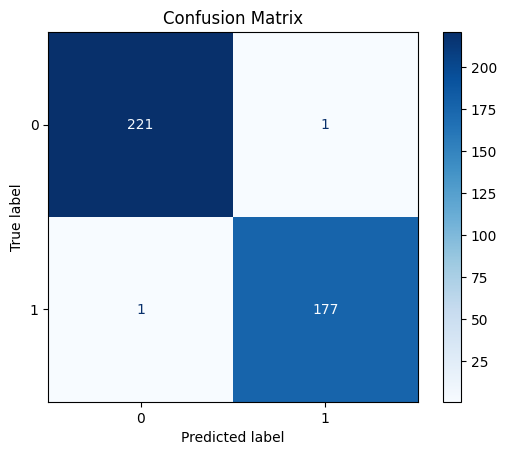

In [ ]:
# Predict on the test dataset
predictions = trainer.predict(test_dataset)

# Extract logits and true labels
logits = predictions.predictions
predicted_labels = np.argmax(logits, axis=1)  # Predicted class
true_labels = predictions.label_ids  # True labels

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Step 5: Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_labels)  # Replace unique_labels with your label names
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Get the attention token

Logits: [[-1.7544956  2.0965064]]


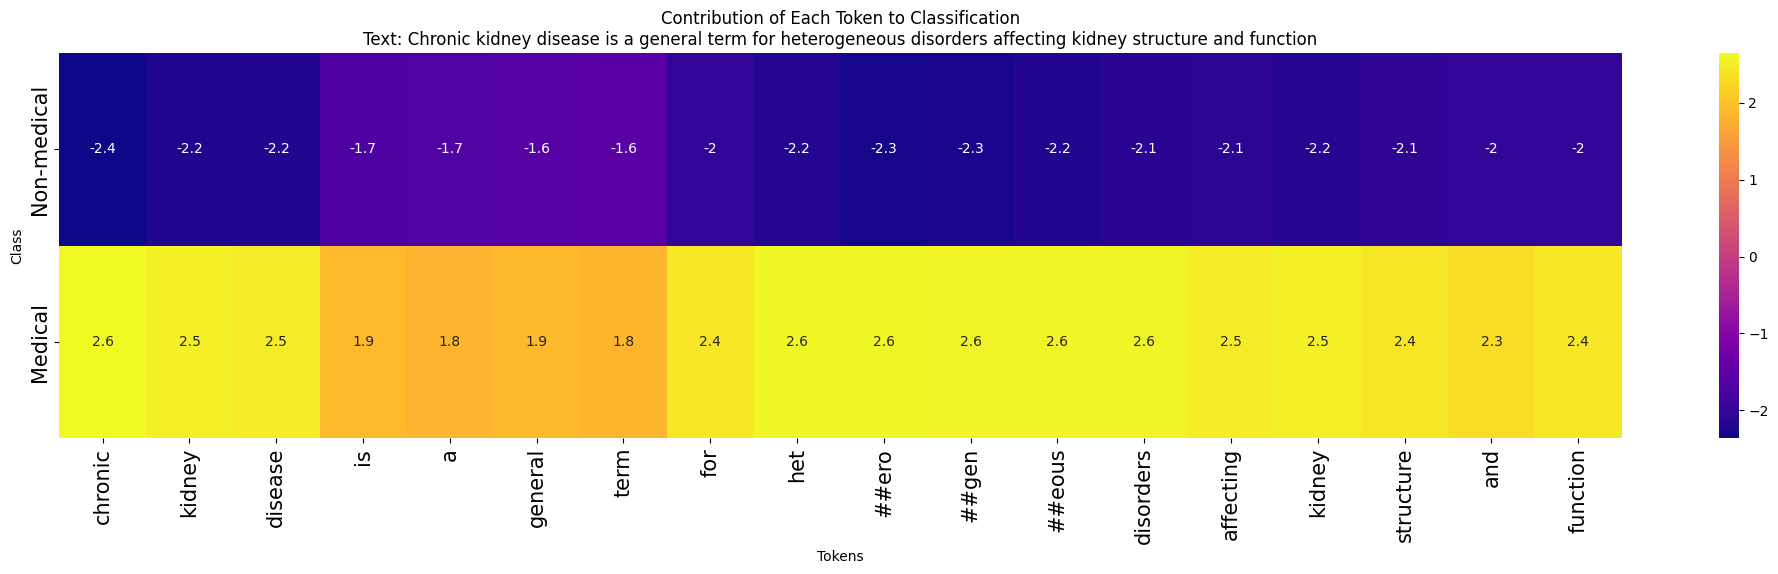

In [ ]:
def get_attentions_token(model, tokenizer, text, device):

    model.eval()
    model.to(device)

    # Tokenize input text
    inputs = tokenizer(
        text,
        return_tensors='pt',
        add_special_tokens=False,  # No [CLS] or [SEP] tokens
        truncation=True,
        max_length=64
    ).to(device)

    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())
    num_tokens = len(tokens)

    # Forward pass to get hidden states and logits
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

    logits = outputs.logits.cpu().detach().numpy()
    print("Logits:", logits)

    # Pass the last hidden state through the classifier
    last_hidden_state = outputs.hidden_states[-1].squeeze(0)
    pre_classifier_output = model.pre_classifier(last_hidden_state)
    classifier_output = model.classifier(pre_classifier_output).cpu().detach().numpy()

    # Plot heatmap
    fig, ax = plt.subplots(figsize=(num_tokens * 1.4, 5))
    sns.heatmap(
        classifier_output.T,
        cmap='plasma',
        xticklabels=tokens,
        yticklabels=['Non-medical', 'Medical'],
        annot=True
    )
    plt.title(f"Contribution of Each Token to Classification\nText: {text}")
    plt.xlabel("Tokens")
    plt.ylabel("Class")
    plt.xticks(rotation=90)
    plt.tick_params(axis='both', which='major', labelsize=15)

    plt.show()

    # Save the heatmap to a file
    fig.savefig('attention.png')

text = "Chronic kidney disease is a general term for heterogeneous disorders affecting kidney structure and function"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

get_attentions_token(model, tokenizer, text, device)
